In [150]:
import pandas as pd
import numpy as np

In [151]:
df = pd.read_csv('Stocks.csv')
# dataframe is not sorted by date, so need to reorder it
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df = df.sort_values('Date').reset_index(drop=True)
df

,Date,TUI,DHER,TMV
0,2022-01-03,16.4907,98.86,12.625
1,2022-01-04,17.7507,92.50,11.950
2,2022-01-05,17.9249,89.76,11.845
3,2022-01-06,17.8552,84.86,11.600
4,2022-01-07,17.9481,85.10,11.395
...,...,...,...,...
890,2025-06-30,7.4180,22.97,9.555
891,2025-07-01,7.7060,23.96,9.485
892,2025-07-02,7.6460,23.77,9.435
893,2025-07-03,7.6200,23.67,9.670


1) a

In [152]:
# Calculate log returns for DHER
# Log return = ln(P_t / P_t-1)
dher_log_returns = np.log(df['DHER'] / df['DHER'].shift(1)).dropna()

# Sample standard deviation gives us volatility
dher_daily_volatility = dher_log_returns.std()

print(f"DHER daily log-return volatility: {dher_daily_volatility:.6f}")

DHER daily log-return volatility: 0.043705


In [153]:
# Scaling volatility using sqrt(time) rule
# Daily volatility is what we just calculated
calendar_day_volatility = dher_daily_volatility

# For trading year: multiply by sqrt(252) since 252 trading days per year
trading_year_volatility = dher_daily_volatility * np.sqrt(252)

# For calendar year: multiply by sqrt(360) since 360 calendar days per year
calendar_year_volatility = dher_daily_volatility * np.sqrt(360)

print(f"(i) Calendar Day: {calendar_day_volatility * 100:.2f}%")
print(f"(ii) Trading year: {trading_year_volatility * 100:.2f}%") 
print(f"(iii) Calendar year: {calendar_year_volatility * 100:.2f}%")

(i) Calendar Day: 4.37%
(ii) Trading year: 69.38%
(iii) Calendar year: 82.92%


2. (a)

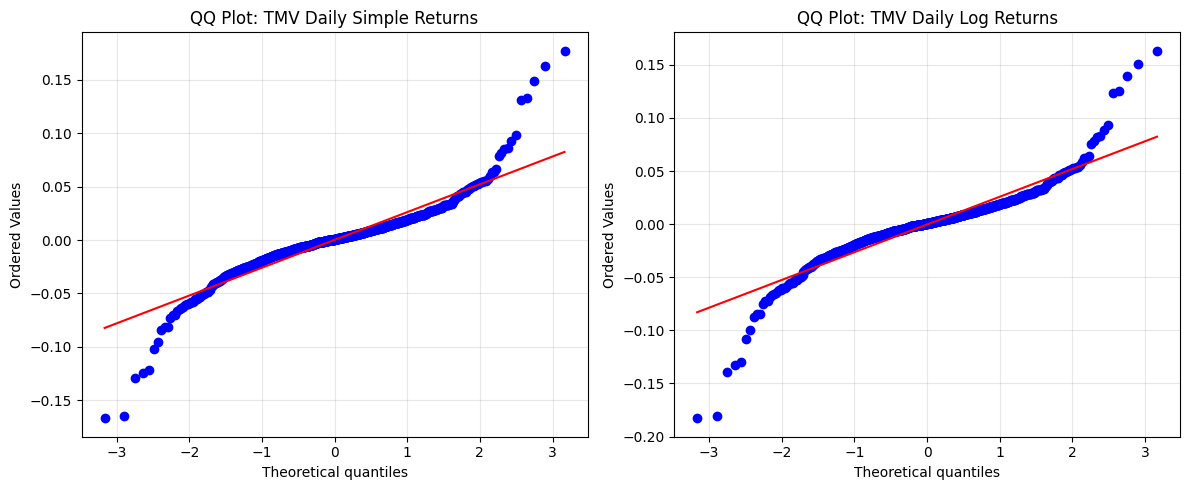

In [154]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculate simple returns: (P_t - P_t-1) / P_t-1
tmv_simple_returns = (df['TMV'] / df['TMV'].shift(1) - 1).dropna()
# Calculate log returns: ln(P_t / P_t-1)
tmv_log_returns = np.log(df['TMV'] / df['TMV'].shift(1)).dropna()

# Make QQ plots to check normality
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Simple returns QQ plot
stats.probplot(tmv_simple_returns, dist="norm", plot=ax1)
ax1.set_title('QQ Plot: TMV Daily Simple Returns')
ax1.grid(True, alpha=0.3)

# Log returns QQ plot
stats.probplot(tmv_log_returns, dist="norm", plot=ax2)
ax2.set_title('QQ Plot: TMV Daily Log Returns')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

2. (c)

Now calculate monthly returns by using the closing stock price at the end of each month from January 2022 to June 2025. Do not include July 2025, as the data for that month is incomplete. Once you have calculated the monthly returns, recreate the QQ plot for TMV to assess how well the monthly simple and log returns follow a normal distribution.

Please upload the plot, for example, as a screenshot.



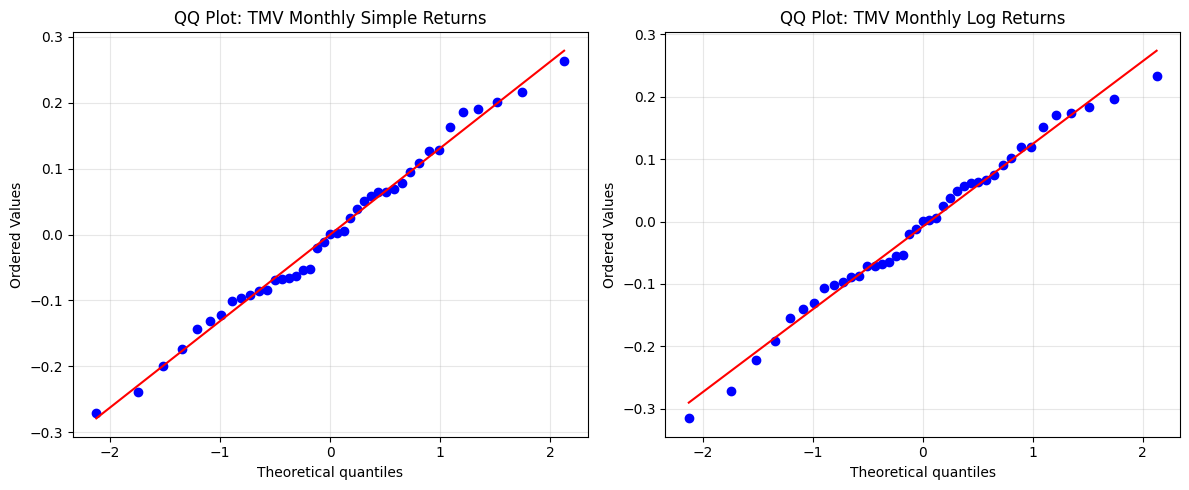

In [155]:
# Monthly returns for TMV from Jan 2022 to June 2025

# Filter the date range (excluding July 2025 as it's incomplete)
monthly_data = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2025-06-30')].copy()

# Get end-of-month prices
monthly_data['YearMonth'] = monthly_data['Date'].dt.to_period('M')
monthly_prices = monthly_data.groupby('YearMonth')['TMV'].last()

# Calculate monthly returns
monthly_simple_returns = (monthly_prices / monthly_prices.shift(1) - 1).dropna()
monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

# QQ plots for monthly data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(monthly_simple_returns, dist="norm", plot=ax1)
ax1.set_title('QQ Plot: TMV Monthly Simple Returns')
ax1.grid(True, alpha=0.3)

stats.probplot(monthly_log_returns, dist="norm", plot=ax2)
ax2.set_title('QQ Plot: TMV Monthly Log Returns')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Part 3

In [156]:
# Calculate simple returns for all stocks
tui_simple_returns = (df['TUI'] / df['TUI'].shift(1) - 1).dropna()
dher_simple_returns = (df['DHER'] / df['DHER'].shift(1) - 1).dropna()
tmv_simple_returns = (df['TMV'] / df['TMV'].shift(1) - 1).dropna()

# Put them in a dataframe for easier correlation calculation
returns_df = pd.DataFrame({
    'TUI': tui_simple_returns,
    'DHER': dher_simple_returns, 
    'TMV': tmv_simple_returns
})

# Correlation matrix
correlation_matrix = returns_df.corr()
print("Pairwise correlations:")
print(correlation_matrix)

# Extract the specific correlations (as percentages)
print(f"\nTUI-DHER correlation: {correlation_matrix.loc['TUI', 'DHER'] * 100:.1f}%")
print(f"TUI-TMV correlation: {correlation_matrix.loc['TUI', 'TMV'] * 100:.1f}%")
print(f"DHER-TMV correlation: {correlation_matrix.loc['DHER', 'TMV'] * 100:.1f}%")

Pairwise correlations:
           TUI      DHER       TMV
TUI   1.000000  0.333600  0.270776
DHER  0.333600  1.000000  0.321433
TMV   0.270776  0.321433  1.000000

TUI-DHER correlation: 33.4%
TUI-TMV correlation: 27.1%
DHER-TMV correlation: 32.1%


b)

In [157]:
# Find minimum variance portfolio weights
# Need the covariance matrix first
cov_matrix = returns_df.cov()

# Minimum variance portfolio formula
inv_cov_matrix = np.linalg.inv(cov_matrix)
ones = np.ones((3, 1))

# Calculate the weights
numerator = inv_cov_matrix @ ones
denominator = ones.T @ inv_cov_matrix @ ones
weights = numerator / denominator

print(f"Minimum-Variance Portfolio Weights:")
print(f"TUI: {weights[0][0] * 100:.1f}%")
print(f"DHER: {weights[1][0] * 100:.1f}%")
print(f"TMV: {weights[2][0] * 100:.1f}%")
print(f"Total: {weights.sum():.1f}")

# Keep these for later calculations
mvp_weights = weights.flatten()

Minimum-Variance Portfolio Weights:
TUI: 40.8%
DHER: 7.6%
TMV: 51.6%
Total: 1.0


3. (c)


In [158]:
# Calculate portfolio return and risk
portfolio_returns = returns_df @ mvp_weights

mvp_expected_return = portfolio_returns.mean()
mvp_std = portfolio_returns.std()

print(f"Minimum-Variance Portfolio:")
print(f"Expected daily return: {mvp_expected_return * 100:.2f}%")
print(f"Daily standard deviation: {mvp_std * 100:.2f}%")

Minimum-Variance Portfolio:
Expected daily return: -0.02%
Daily standard deviation: 2.28%


3. (d)

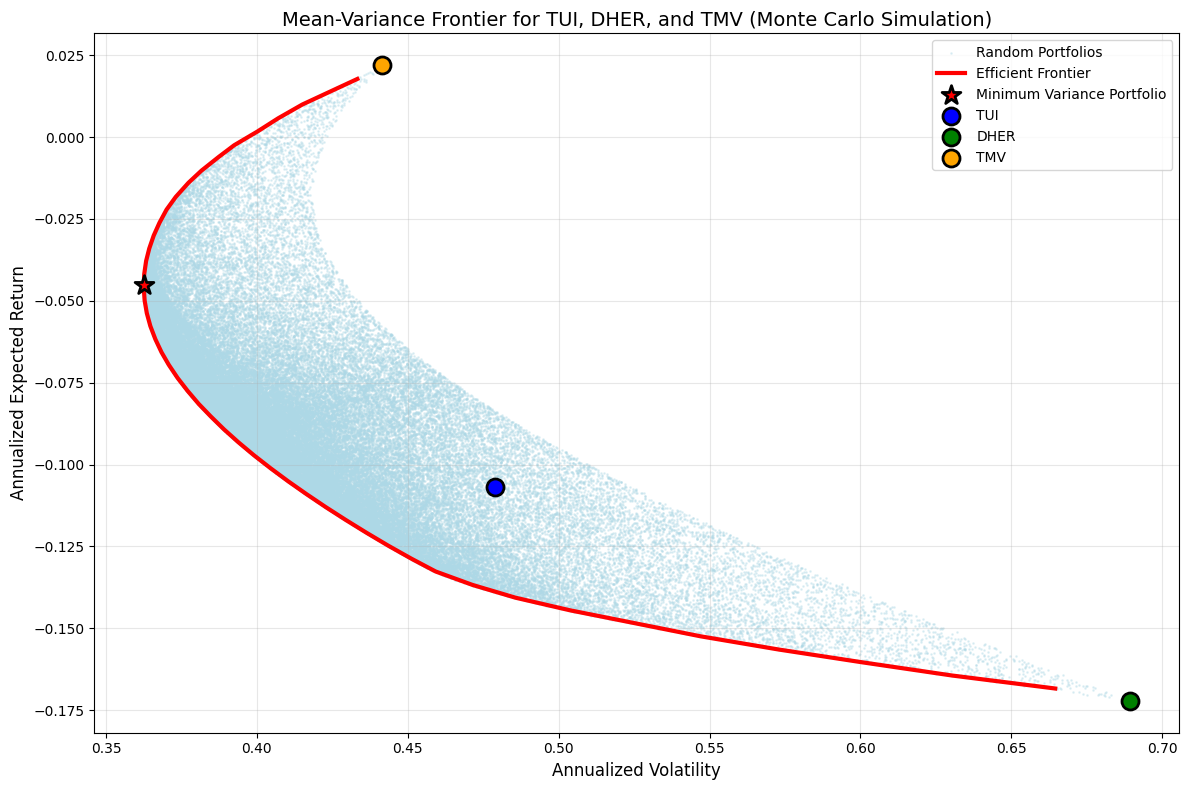

Simulated 100,000 random portfolios
MVP (analytical): return = -0.0453 (-4.53%), volatility = 0.3625 (36.25%)
Min simulated volatility: 0.3625
Max simulated return: 0.0212

Individual stocks (annualized):
TUI: return = -0.1068 (-10.68%), volatility = 0.4788 (47.88%)
DHER: return = -0.1722 (-17.22%), volatility = 0.6893 (68.93%)
TMV: return = 0.0220 (2.20%), volatility = 0.4415 (44.15%)


In [ ]:
# Plot the mean-variance frontier using Monte Carlo simulation
import matplotlib.pyplot as plt
np.random.seed(42)  # For reproducible results

# Get expected returns and covariance matrix from our existing data
expected_returns = returns_df.mean().values
cov_matrix_values = cov_matrix.values

# Generate 100,000 random portfolios
num_portfolios = 100000
portfolio_returns = []
portfolio_volatilities = []

for i in range(num_portfolios):
    # Generate random weights that sum to 1
    weights = np.random.random(3)
    weights = weights / np.sum(weights)  # Normalize to sum to 1
    
    # Calculate portfolio return and volatility
    port_return = np.sum(weights * expected_returns)
    port_variance = np.dot(weights.T, np.dot(cov_matrix_values, weights))
    port_volatility = np.sqrt(port_variance)
    
    portfolio_returns.append(port_return)
    portfolio_volatilities.append(port_volatility)

# Convert to annual figures (252 trading days)
portfolio_returns = np.array(portfolio_returns) * 252
portfolio_volatilities = np.array(portfolio_volatilities) * np.sqrt(252)

# Calculate our analytical MVP for comparison
mvp_annual_return = mvp_expected_return * 252
mvp_annual_volatility = mvp_std * np.sqrt(252)

# Individual stocks annualized
annual_stock_returns = expected_returns * 252
annual_stock_volatilities = returns_df.std().values * np.sqrt(252)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot all simulated portfolios as scatter points
plt.scatter(portfolio_volatilities, portfolio_returns, c='lightblue', alpha=0.3, s=1, label='Random Portfolios')

# Highlight the efficient frontier by finding the minimum volatility for each return level
# Sort by return and find efficient portfolios
sorted_indices = np.argsort(portfolio_returns)
sorted_returns = portfolio_returns[sorted_indices]
sorted_volatilities = portfolio_volatilities[sorted_indices]

# Find efficient frontier points (minimum volatility for each return level)
efficient_vols = []
efficient_rets = []
return_bins = np.linspace(sorted_returns.min(), sorted_returns.max(), 50)

for i in range(len(return_bins)-1):
    ret_min, ret_max = return_bins[i], return_bins[i+1]
    mask = (sorted_returns >= ret_min) & (sorted_returns < ret_max)
    if np.any(mask):
        min_vol_idx = np.argmin(sorted_volatilities[mask])
        efficient_vols.append(sorted_volatilities[mask][min_vol_idx])
        efficient_rets.append(sorted_returns[mask][min_vol_idx])

# Plot efficient frontier
plt.plot(efficient_vols, efficient_rets, 'r-', linewidth=3, label='Efficient Frontier')

# Plot MVP
plt.scatter(mvp_annual_volatility, mvp_annual_return, color='red', s=200, marker='*', 
           edgecolors='black', linewidth=2, label='Minimum Variance Portfolio', zorder=5)

# Add individual stocks
stock_names = ['TUI', 'DHER', 'TMV']
colors = ['blue', 'green', 'orange']
for i, (name, color) in enumerate(zip(stock_names, colors)):
    plt.scatter(annual_stock_volatilities[i], annual_stock_returns[i], 
               color=color, s=150, marker='o', edgecolors='black', linewidth=2, label=name, zorder=4)

plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.title('Mean-Variance Frontier for TUI, DHER, and TMV (Monte Carlo Simulation)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

2024+ data has 382 observations


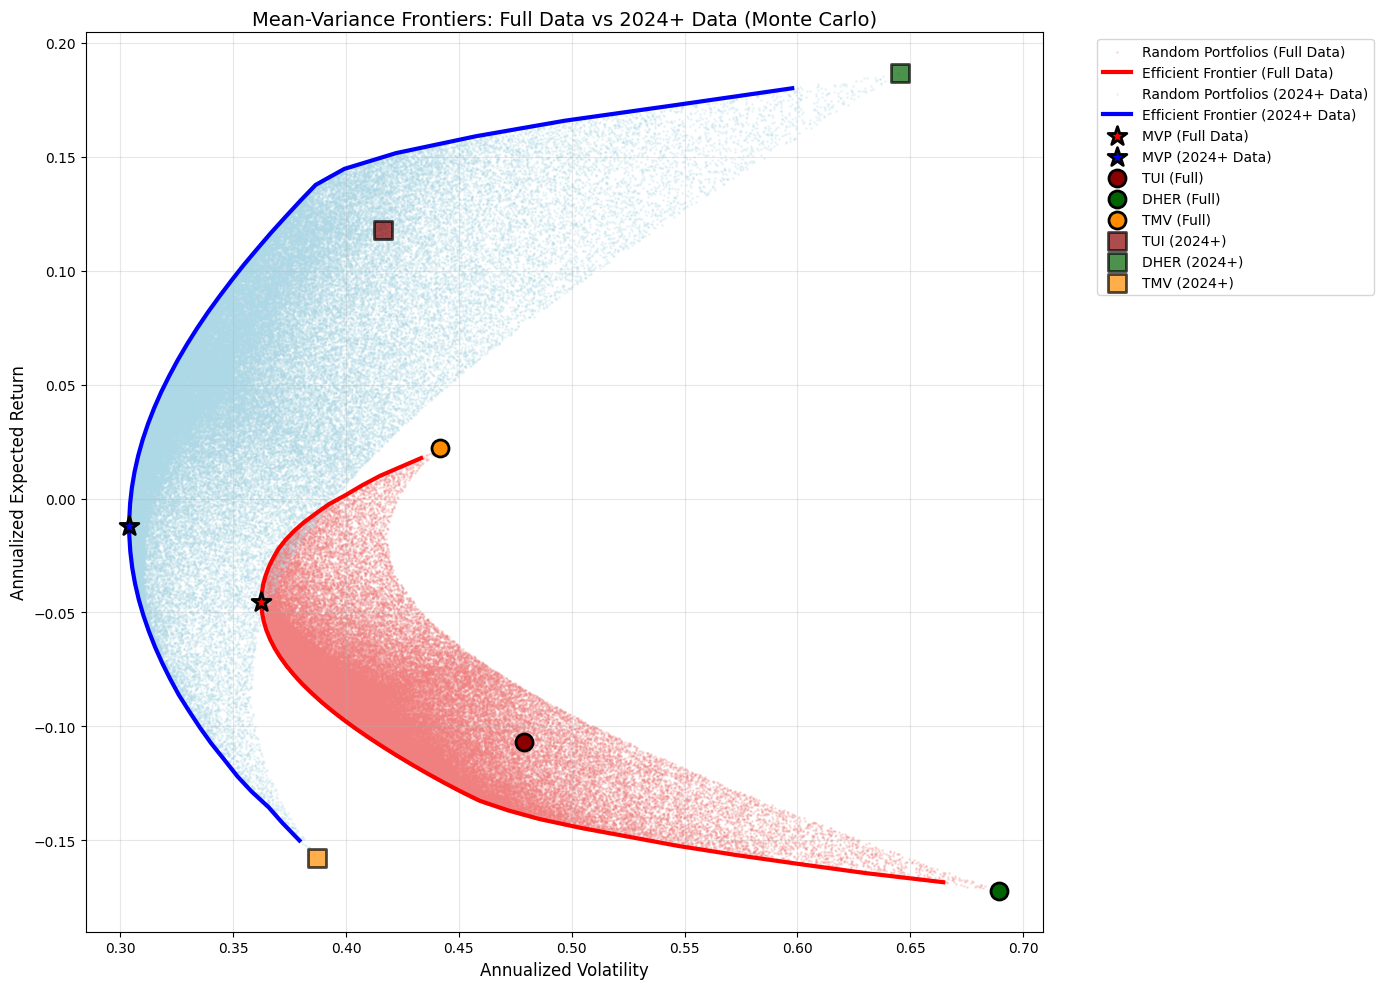

Full data MVP: return = -0.0453 (-4.53%), vol = 0.3625 (36.25%)
2024+ MVP: return = -0.0123 (-1.23%), vol = 0.3040 (30.40%)
Monte Carlo simulation gives smooth, natural-looking efficient frontiers!


In [ ]:
# Add the 2024+ frontier using Monte Carlo simulation
df_2024 = df[df['Date'] >= '2024-01-01'].copy()

# Calculate returns for recent period only
tui_returns_2024 = (df_2024['TUI'] / df_2024['TUI'].shift(1) - 1).dropna()
dher_returns_2024 = (df_2024['DHER'] / df_2024['DHER'].shift(1) - 1).dropna()
tmv_returns_2024 = (df_2024['TMV'] / df_2024['TMV'].shift(1) - 1).dropna()

returns_2024_df = pd.DataFrame({
    'TUI': tui_returns_2024,
    'DHER': dher_returns_2024,
    'TMV': tmv_returns_2024
})

print(f"2024+ data has {len(returns_2024_df)} observations")

expected_returns_2024 = returns_2024_df.mean().values
cov_matrix_2024 = returns_2024_df.cov().values

# Calculate analytical MVP for 2024+ data
inv_cov_2024 = np.linalg.inv(cov_matrix_2024)
ones = np.ones((3, 1))
mvp_weights_2024 = (inv_cov_2024 @ ones) / (ones.T @ inv_cov_2024 @ ones)
mvp_return_2024 = (expected_returns_2024 @ mvp_weights_2024.flatten())
mvp_vol_2024 = np.sqrt(mvp_weights_2024.T @ cov_matrix_2024 @ mvp_weights_2024)[0][0]

# Generate random portfolios for 2024+ data
num_portfolios = 100000
portfolio_returns_2024 = []
portfolio_volatilities_2024 = []

np.random.seed(42)  # Same seed for consistency
for i in range(num_portfolios):
    weights = np.random.random(3)
    weights = weights / np.sum(weights)
    
    port_return = np.sum(weights * expected_returns_2024)
    port_variance = np.dot(weights.T, np.dot(cov_matrix_2024, weights))
    port_volatility = np.sqrt(port_variance)
    
    portfolio_returns_2024.append(port_return)
    portfolio_volatilities_2024.append(port_volatility)

# Annualize 2024+ data
portfolio_returns_2024 = np.array(portfolio_returns_2024) * 252
portfolio_volatilities_2024 = np.array(portfolio_volatilities_2024) * np.sqrt(252)

mvp_annual_return_2024 = mvp_return_2024 * 252
mvp_annual_vol_2024 = mvp_vol_2024 * np.sqrt(252)

# Find efficient frontier for 2024+ data
sorted_indices_2024 = np.argsort(portfolio_returns_2024)
sorted_returns_2024 = portfolio_returns_2024[sorted_indices_2024]
sorted_volatilities_2024 = portfolio_volatilities_2024[sorted_indices_2024]

efficient_vols_2024 = []
efficient_rets_2024 = []
return_bins_2024 = np.linspace(sorted_returns_2024.min(), sorted_returns_2024.max(), 50)

for i in range(len(return_bins_2024)-1):
    ret_min, ret_max = return_bins_2024[i], return_bins_2024[i+1]
    mask = (sorted_returns_2024 >= ret_min) & (sorted_returns_2024 < ret_max)
    if np.any(mask):
        min_vol_idx = np.argmin(sorted_volatilities_2024[mask])
        efficient_vols_2024.append(sorted_volatilities_2024[mask][min_vol_idx])
        efficient_rets_2024.append(sorted_returns_2024[mask][min_vol_idx])

# Plot both frontiers together
plt.figure(figsize=(14, 10))

# Original data (full period) - red
plt.scatter(portfolio_volatilities, portfolio_returns, c='lightcoral', alpha=0.2, s=1, label='Random Portfolios (Full Data)')
plt.plot(efficient_vols, efficient_rets, 'r-', linewidth=3, label='Efficient Frontier (Full Data)')

# 2024+ data - blue
plt.scatter(portfolio_volatilities_2024, portfolio_returns_2024, c='lightblue', alpha=0.2, s=1, label='Random Portfolios (2024+ Data)')
plt.plot(efficient_vols_2024, efficient_rets_2024, 'b-', linewidth=3, label='Efficient Frontier (2024+ Data)')

# MVP points
plt.scatter(mvp_annual_volatility, mvp_annual_return, color='red', s=200, marker='*', 
           edgecolors='black', linewidth=2, label='MVP (Full Data)', zorder=5)
plt.scatter(mvp_annual_vol_2024, mvp_annual_return_2024, color='blue', s=200, marker='*', 
           edgecolors='black', linewidth=2, label='MVP (2024+ Data)', zorder=5)

# Individual stocks - full data
stock_names = ['TUI', 'DHER', 'TMV']
colors = ['darkred', 'darkgreen', 'darkorange']
for i, (name, color) in enumerate(zip(stock_names, colors)):
    plt.scatter(annual_stock_volatilities[i], annual_stock_returns[i], 
               color=color, s=150, marker='o', edgecolors='black', linewidth=2, label=f'{name} (Full)', zorder=4)

# Individual stocks - 2024+ data  
annual_stock_returns_2024 = expected_returns_2024 * 252
annual_stock_volatilities_2024 = returns_2024_df.std().values * np.sqrt(252)

for i, (name, color) in enumerate(zip(stock_names, colors)):
    plt.scatter(annual_stock_volatilities_2024[i], annual_stock_returns_2024[i], 
               color=color, s=150, marker='s', edgecolors='black', linewidth=2, alpha=0.7, label=f'{name} (2024+)', zorder=4)

plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.title('Mean-Variance Frontiers: Full Data vs 2024+ Data (Monte Carlo)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

3. (h)


Restricted portfolio uses 382 observations from 2024+
Assets: DHER and TMV only (TUI excluded due to ESG regulations)

Restricted MVP weights:
DHER: 21.5%
TMV: 78.5%


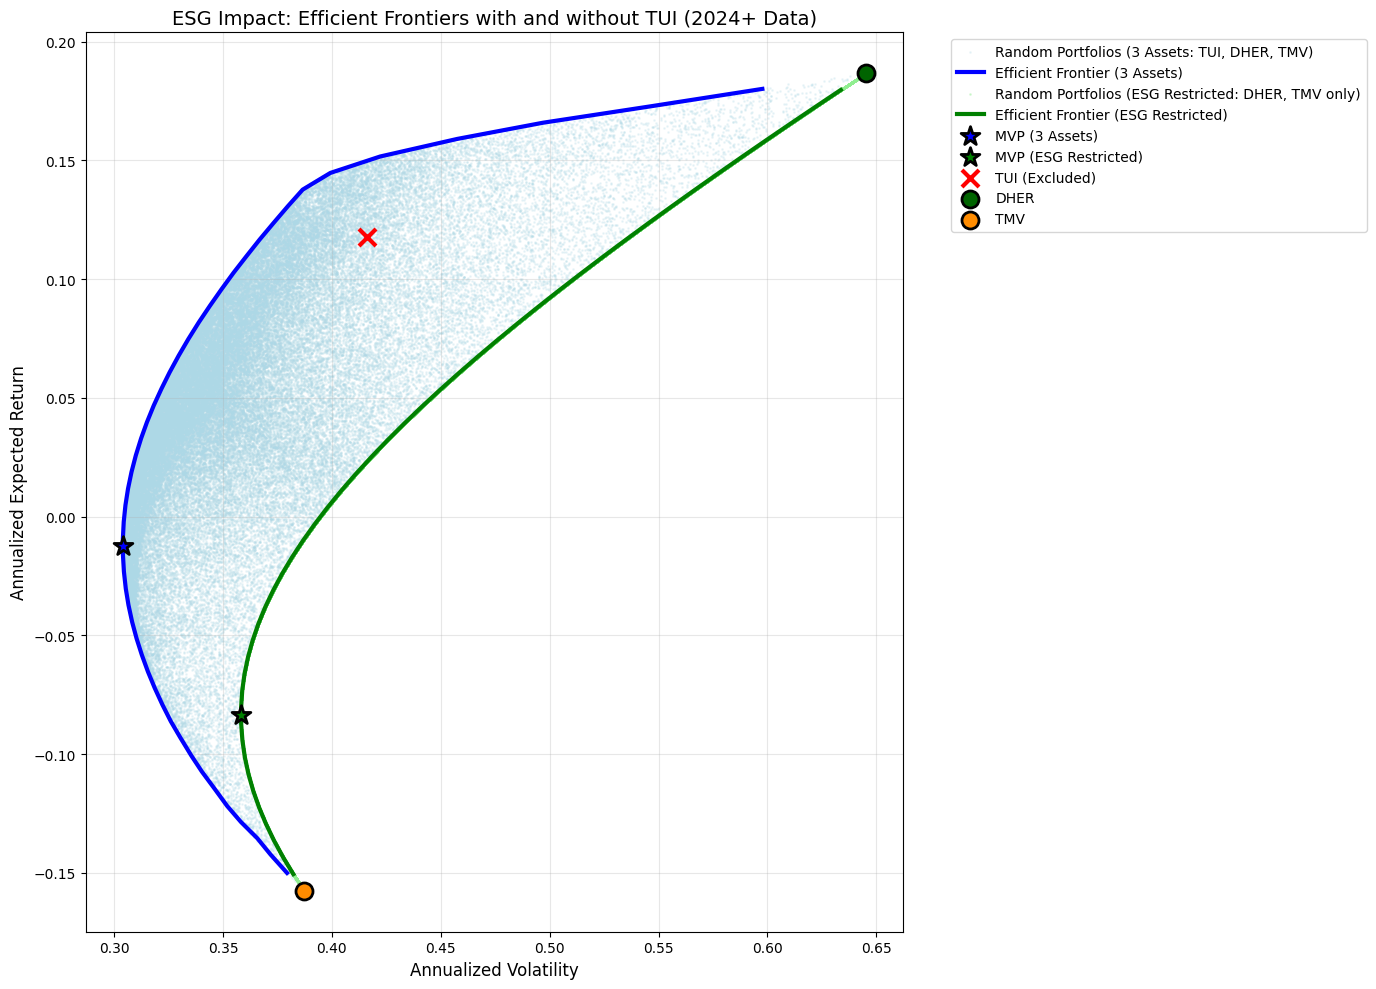


=== COMPARISON OF MINIMUM VARIANCE PORTFOLIOS ===
3-Asset MVP (TUI, DHER, TMV): return = -0.0123 (-1.23%), vol = 0.3040 (30.40%)
ESG Restricted MVP (DHER, TMV): return = -0.0834 (-8.34%), vol = 0.3582 (35.82%)

=== COST OF ESG RESTRICTION ===
Volatility increase: 0.0543 (5.43 percentage points)
Return change: -0.0712 (-7.12 percentage points)
ESG restriction leads to higher risk and lower expected return


In [ ]:
# Use only DHER and TMV from 2024+ data
returns_restricted_df = returns_2024_df[['DHER', 'TMV']].copy()

expected_returns_restricted = returns_restricted_df.mean().values
cov_matrix_restricted = returns_restricted_df.cov().values

# Calculate analytical MVP for restricted portfolio (2 assets)
inv_cov_restricted = np.linalg.inv(cov_matrix_restricted)
ones_restricted = np.ones((2, 1))
mvp_weights_restricted = (inv_cov_restricted @ ones_restricted) / (ones_restricted.T @ inv_cov_restricted @ ones_restricted)
mvp_return_restricted = (expected_returns_restricted @ mvp_weights_restricted.flatten())
mvp_vol_restricted = np.sqrt(mvp_weights_restricted.T @ cov_matrix_restricted @ mvp_weights_restricted)[0][0]

print(f"\nRestricted MVP weights:")
print(f"DHER: {mvp_weights_restricted[0][0] * 100:.1f}%")
print(f"TMV: {mvp_weights_restricted[1][0] * 100:.1f}%")

# Generate random portfolios for restricted case
num_portfolios = 100000
portfolio_returns_restricted = []
portfolio_volatilities_restricted = []

np.random.seed(42)  # Same seed for consistency
for i in range(num_portfolios):
    # Generate random weights for 2 assets that sum to 1
    weights = np.random.random(2)
    weights = weights / np.sum(weights)
    
    port_return = np.sum(weights * expected_returns_restricted)
    port_variance = np.dot(weights.T, np.dot(cov_matrix_restricted, weights))
    port_volatility = np.sqrt(port_variance)
    
    portfolio_returns_restricted.append(port_return)
    portfolio_volatilities_restricted.append(port_volatility)

# Annualize restricted portfolio data
portfolio_returns_restricted = np.array(portfolio_returns_restricted) * 252
portfolio_volatilities_restricted = np.array(portfolio_volatilities_restricted) * np.sqrt(252)

mvp_annual_return_restricted = mvp_return_restricted * 252
mvp_annual_vol_restricted = mvp_vol_restricted * np.sqrt(252)

# Find efficient frontier for restricted portfolio
sorted_indices_restricted = np.argsort(portfolio_returns_restricted)
sorted_returns_restricted = portfolio_returns_restricted[sorted_indices_restricted]
sorted_volatilities_restricted = portfolio_volatilities_restricted[sorted_indices_restricted]

efficient_vols_restricted = []
efficient_rets_restricted = []
return_bins_restricted = np.linspace(sorted_returns_restricted.min(), sorted_returns_restricted.max(), 50)

for i in range(len(return_bins_restricted)-1):
    ret_min, ret_max = return_bins_restricted[i], return_bins_restricted[i+1]
    mask = (sorted_returns_restricted >= ret_min) & (sorted_returns_restricted < ret_max)
    if np.any(mask):
        min_vol_idx = np.argmin(sorted_volatilities_restricted[mask])
        efficient_vols_restricted.append(sorted_volatilities_restricted[mask][min_vol_idx])
        efficient_rets_restricted.append(sorted_returns_restricted[mask][min_vol_idx])

# Plot comparison: 3-asset vs 2-asset (restricted) frontiers
plt.figure(figsize=(14, 10))

# 2024+ data with all 3 assets (blue)
plt.scatter(portfolio_volatilities_2024, portfolio_returns_2024, c='lightblue', alpha=0.2, s=1, label='Random Portfolios (3 Assets: TUI, DHER, TMV)')
plt.plot(efficient_vols_2024, efficient_rets_2024, 'b-', linewidth=3, label='Efficient Frontier (3 Assets)')

# Restricted data with 2 assets only (green)
plt.scatter(portfolio_volatilities_restricted, portfolio_returns_restricted, c='lightgreen', alpha=0.3, s=1, label='Random Portfolios (ESG Restricted: DHER, TMV only)')
plt.plot(efficient_vols_restricted, efficient_rets_restricted, 'g-', linewidth=3, label='Efficient Frontier (ESG Restricted)')

# MVP points
plt.scatter(mvp_annual_vol_2024, mvp_annual_return_2024, color='blue', s=200, marker='*', 
           edgecolors='black', linewidth=2, label='MVP (3 Assets)', zorder=5)
plt.scatter(mvp_annual_vol_restricted, mvp_annual_return_restricted, color='green', s=200, marker='*', 
           edgecolors='black', linewidth=2, label='MVP (ESG Restricted)', zorder=5)

# Individual stocks from 2024+ data
stock_names_all = ['TUI', 'DHER', 'TMV']
colors_all = ['red', 'darkgreen', 'darkorange']
for i, (name, color) in enumerate(zip(stock_names_all, colors_all)):
    if name == 'TUI':
        # Mark TUI as excluded
        plt.scatter(annual_stock_volatilities_2024[i], annual_stock_returns_2024[i], 
                   color=color, s=150, marker='x', linewidth=3, label=f'{name} (Excluded)', zorder=4)
    else:
        plt.scatter(annual_stock_volatilities_2024[i], annual_stock_returns_2024[i], 
                   color=color, s=150, marker='o', edgecolors='black', linewidth=2, label=f'{name}', zorder=4)

plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.title('ESG Impact: Efficient Frontiers with and without TUI (2024+ Data)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()